In [1]:
# Load modules

import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import zarr
import gcsfs
import warnings

In [2]:
vert_ds = xr.open_dataarray('/data/keeling/a/mailes2/cesmle_variability_analysis/processed_data/vert_ds.nc')

In [3]:
def monthly_fit(sst_dataset, toa_dataset):
    """
    Monthly regression
    
    """
    # Remove seasonality
    climatology_sst = sst_dataset.groupby('time.month').mean('time')
    sst_anomalies = sst_dataset.groupby('time.month') - climatology_sst
    climatology_toa = toa_dataset.groupby('time.month').mean('time')
    toa_anomalies = toa_dataset.groupby('time.month') - climatology_toa
    
    SST_TOAfit = xr.DataArray(np.zeros((15,88,179)), dims=['name','lat','lon'])
    model_index = 0
    for model in toa_dataset.coords['name'].values:
        lat_index = 0
        for lat in toa_dataset.coords['lat'].values:
            lon_index = 0
            for lon in toa_dataset.coords['lon'].values:
                SST_slice = sst_anomalies.sel(lat=lat).sel(lon=lon).sel(name=model)
                TOA_slice = toa_anomalies.sel(lat=lat).sel(lon=lon).sel(name=model)
                idx = np.isfinite(SST_slice) & np.isfinite(TOA_slice)
                if not SST_slice[idx].size or not TOA_slice[idx].size:
                    break
                SST_TOAfit[model_index, lat_index, lon_index] = np.polyfit(SST_slice[idx], TOA_slice[idx], deg=1)[0]     
                lon_index += 1
            lat_index += 1
        model_index += 1
        print(model)

    SST_TOAfit.coords['lon'] = toa_dataset['lon'].values
    SST_TOAfit.coords['lat'] = toa_dataset['lat'].values
    SST_TOAfit.coords['name'] = toa_dataset['name'].values
    SST_TOAfit
    return SST_TOAfit

# Control SST + TOA

In [4]:
dataarray_SST_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_sst_piControl_interp_2x2_15memens_3.nc')
dataarray_SST_cont.load()

<xarray.DataArray 'ts' (name: 15, time: 1800, lat: 88, lon: 179)>
array([[[[243.18496246, 243.0430336 , 242.90864563, ..., 243.75744705,
          243.6136322 , 243.47025681],
         [243.91621094, 243.58426437, 243.37599564, ..., 245.18914566,
          244.86694336, 244.54597549],
         [245.59149551, 245.1326683 , 244.65911102, ..., 247.68568878,
          247.14878464, 246.61694489],
         ...,
         [239.55025787, 239.92131195, 240.25101852, ..., 237.72741852,
          237.87510681, 238.06498566],
         [238.32813339, 238.6320961 , 238.78931427, ..., 237.56899948,
          237.70903015, 237.84785614],
         [236.66961594, 236.70400772, 236.74081421, ..., 236.53036346,
          236.56542206, 236.60032578]],

        [[231.3177597 , 231.15438766, 231.01077652, ..., 231.97694626,
          231.81131363, 231.64621048],
         [232.09978867, 231.65678024, 231.46744919, ..., 233.87158051,
          233.43950653, 233.00966873],
         [234.51739807, 234.01972885, 233.50682068, ..., 237.02090225,
          236.37061691, 235.73139725],
...
         [236.21630066, 236.41590355, 236.61564204, ..., 235.54121697,
          235.48484011, 235.62871534],
         [235.7615734 , 235.75446825, 235.68558256, ..., 235.16832016,
          235.07757449, 235.21519248],
         [233.91476264, 233.92667082, 233.89350286, ..., 233.50961941,
          233.46821828, 233.55730458]],

        [[242.75259891, 242.68326074, 242.66877344, ..., 243.78897623,
          243.58508976, 243.22465703],
         [242.03332321, 241.91772399, 241.89358867, ..., 243.7606035 ,
          243.42067573, 242.82000536],
         [243.07760255, 242.78785914, 242.30024329, ..., 245.10339405,
          244.47122299, 243.80644261],
         ...,
         [234.80622118, 235.27589037, 235.74677416, ..., 232.50746223,
          233.02922355, 233.63228052],
         [231.77566348, 232.06172021, 232.25882711, ..., 229.94323198,
          230.36028449, 230.8487199 ],
         [229.72607924, 229.92453213, 230.05266565, ..., 228.49337449,
          228.76906986, 229.07961463]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2000-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'GFDL-CM4' 'GFDL-ESM4' ... 'MIROC6' 'FGOALS-g3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Temperature
    original_name:  ts
    standard_name:  surface_temperature
    units:          K

In [13]:
dataarray_TOA_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_piControl_2x2_15memens_3.nc')
dataarray_TOA_cont.load()

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[ -36.71150756,  -36.54298704,  -36.33610696, ...,
           -37.38284098,  -37.20380278,  -36.99700632],
         [ -38.26714412,  -37.84095571,  -37.39639549, ...,
           -40.08008474,  -39.55886911,  -39.16305471],
         [ -41.73647855,  -41.19594878,  -40.66258   , ...,
           -43.8332355 ,  -43.39299072,  -42.8394849 ],
         ...,
         [-157.2955542 , -157.20398975, -157.24631113, ...,
          -157.04223199, -157.12361213, -157.20145457],
         [-157.91162539, -157.93890508, -157.92696253, ...,
          -158.0758101 , -158.08202094, -157.97277022],
         [-158.18000831, -158.15537339, -158.11918551, ...,
          -158.34951912, -158.36058747, -158.20792706]],

        [[ -72.54225605,  -72.23584524,  -71.96492355, ...,
           -73.75649012,  -73.41867717,  -73.11533206],
         [ -74.15452931,  -73.55173268,  -73.10056357, ...,
           -76.46964449,  -75.84088912,  -75.23099848],
         [ -76.72662193,  -75.94243471,  -75.26338409, ...,
           -80.29527136,  -79.42623765,  -78.51133988],
...
         [-189.22492955, -189.30227199, -189.28175208, ...,
          -187.94592604, -188.71010913, -189.08596034],
         [-187.66484428, -187.79513177, -187.73868456, ...,
          -186.73131523, -187.09540344, -187.45035853],
         [-186.2369766 , -186.30932083, -186.26637199, ...,
          -185.80490602, -186.10912712, -186.35954494]],

        [[ -29.50503287,  -29.43086169,  -29.31137194, ...,
           -29.98075315,  -29.86748574,  -29.73026972],
         [ -30.19279811,  -29.98313162,  -29.78658468, ...,
           -31.33691942,  -31.06372967,  -30.83990153],
         [ -33.26394077,  -32.856983  ,  -32.52524423, ...,
           -34.16527285,  -34.01342119,  -33.83656878],
         ...,
         [-175.9038306 , -176.5571139 , -177.43475613, ...,
          -173.45573242, -174.40393815, -174.87004663],
         [-173.56898899, -174.03891795, -174.378321  , ...,
          -172.63712837, -172.83401715, -173.04569349],
         [-172.22648142, -172.47628669, -172.66934056, ...,
          -171.89836076, -171.97250792, -172.02929219]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'IPSL-CM6A-LR'

## Done without seasonality removed

In [20]:
model_index = 0
dataarray_SST = dataarray_SST.isel(time=slice(0,1500))

SST_TOAfit = xr.DataArray(np.zeros((15,88,179)), dims=['name','lat','lon'])

for model in dataarray_TOA.coords['name'].values:
    lat_index = 0
    for lat in dataarray_TOA.coords['lat'].values:
        lon_index = 0
        for lon in dataarray_TOA.coords['lon'].values:
            #SST_TOAfit[model_index, lat_index, lon_index] = np.polyfit(dataarray_SST.sel(lat=lat).sel(lon=lon).sel(name=model), 
            #                                                           dataarray_TOA.sel(lat=lat).sel(lon=lon).sel(name=model), deg=1)
            SST_slice = dataarray_SST.sel(lat=lat).sel(lon=lon).sel(name=model)
            TOA_slice = dataarray_TOA.sel(lat=lat).sel(lon=lon).sel(name=model)
            idx = np.isfinite(SST_slice) & np.isfinite(TOA_slice)
            if not SST_slice[idx].size or not TOA_slice[idx].size:
                break
            SST_TOAfit[model_index, lat_index, lon_index] = np.polyfit(SST_slice[idx], TOA_slice[idx], deg=1)[0]     
            lon_index += 1
        lat_index += 1
    model_index += 1
    print(model)

            
SST_TOAfit.coords['lon'] = dataarray_SST['lon'].values
SST_TOAfit.coords['lat'] = dataarray_SST['lat'].values
SST_TOAfit.coords['name'] = dataarray_SST['name'].values
SST_TOAfit

BCC-CSM2-MR
BCC-ESM1
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
GISS-E2-1-G
HadGEM3-GC31-LL
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
GFDL-CM4
GFDL-ESM4
GISS-E2-1-H


<xarray.DataArray (name: 15, lat: 88, lon: 179)>
array([[[3.07766536, 3.06076531, 3.04643553, ..., 3.16291096,
         3.1385411 , 3.11724952],
        [2.99204716, 2.96106296, 2.93557295, ..., 3.1619912 ,
         3.11204265, 3.06833671],
        [2.96505243, 2.91438379, 2.87260378, ..., 3.2498782 ,
         3.16824727, 3.09280235],
        ...,
        [3.68298997, 3.6669659 , 3.64725008, ..., 3.67183646,
         3.68099258, 3.6749783 ],
        [3.55731545, 3.55764372, 3.56750296, ..., 3.53469064,
         3.53587188, 3.53898794],
        [3.47002377, 3.47653974, 3.4796431 , ..., 3.43624493,
         3.44897967, 3.45286734]],

       [[3.04762965, 3.03245853, 3.01830032, ..., 3.10961519,
         3.09372152, 3.07817657],
        [2.91995427, 2.89483905, 2.87145876, ..., 3.03052192,
         3.00140137, 2.97368278],
        [2.85208078, 2.82692118, 2.80253195, ..., 2.97648968,
         2.94184887, 2.90946106],
...
        [3.42043843, 3.44049264, 3.46414405, ..., 3.30987296,
         3.34172019, 3.37151664],
        [3.08754568, 3.11136111, 3.13375094, ..., 3.01794685,
         3.03512592, 3.05176775],
        [2.95640608, 2.9645851 , 2.97332064, ..., 2.92217982,
         2.93095848, 2.9395914 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) object 'GFDL-CM4' 'GFDL-ESM4' ... 'HadGEM3-GC31-LL'

In [21]:
SST_TOAfit_mean = SST_TOAfit.mean('name')

Text(0.5, 1.0, 'Regression of piControl SST and TOA Radiation (N=15)')

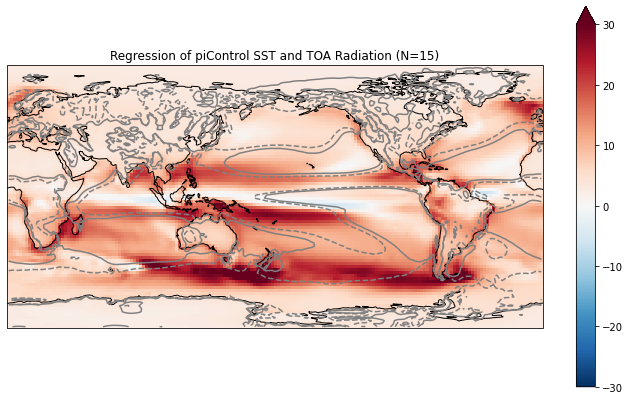

In [30]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
SST_TOAfit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-30, vmax=30, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Regression of piControl SST and TOA Radiation (N=15)')

## With seasonality removed

In [14]:
dataarray_SST_cont = dataarray_SST_cont.isel(time=slice(0,1500))
sst_toa_fit_cont = monthly_fit(dataarray_SST_cont, dataarray_TOA_cont)
sst_toa_fit_cont

BCC-CSM2-MR
BCC-ESM1
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
FGOALS-g3
HadGEM3-GC31-LL
MIROC6
MPI-ESM-1-2-HAM
GFDL-CM4
GFDL-ESM4
E3SM-1-0
GISS-E2-1-G
IPSL-CM6A-LR


<xarray.DataArray (name: 15, lat: 88, lon: 179)>
array([[[-0.80147645, -0.81291285, -0.82498554, ..., -0.75285759,
         -0.76512863, -0.77699638],
        [-0.75200388, -0.77095548, -0.79039249, ..., -0.67217252,
         -0.69291175, -0.71293775],
        [-0.71448629, -0.74231112, -0.76878612, ..., -0.59070572,
         -0.6234153 , -0.65507976],
        ...,
        [-1.05162632, -1.04954711, -1.04327022, ..., -1.05536212,
         -1.05588012, -1.05458667],
        [-1.06898572, -1.06795907, -1.06787004, ..., -1.07292437,
         -1.07340228, -1.07151193],
        [-1.08164072, -1.07992045, -1.0791422 , ..., -1.08840772,
         -1.08833751, -1.08764163]],

       [[-0.82233438, -0.83335239, -0.84326845, ..., -0.77982973,
         -0.79061421, -0.80027401],
        [-0.82274083, -0.84330047, -0.86369893, ..., -0.74282355,
         -0.76209911, -0.78243333],
        [-0.85326479, -0.8853628 , -0.91655095, ..., -0.7294822 ,
         -0.7598056 , -0.79126856],
...
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-1.53855493, -1.53903676, -1.54032956, ..., -1.53449455,
         -1.5358266 , -1.53642418],
        [-1.5203477 , -1.52017473, -1.5243496 , ..., -1.51634096,
         -1.51784094, -1.51580835],
        [-1.49382107, -1.49357994, -1.49136566, ..., -1.48620212,
         -1.49173674, -1.49019136],
        ...,
        [-1.00313833, -0.99779686, -0.99308458, ..., -0.97395553,
         -0.98728985, -0.99345405],
        [-1.04539184, -1.04155699, -1.03728564, ..., -1.04629153,
         -1.04664222, -1.04299899],
        [-1.08116072, -1.08035958, -1.07856686, ..., -1.08899074,
         -1.08506856, -1.07764736]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'IPSL-CM6A-LR'

In [15]:
sst_toa_fit_cont_mean = sst_toa_fit_cont.mean('name')

Text(0.5, 1.0, 'Monthly Regression of piControl SST and TOA Radiation (N=15)')

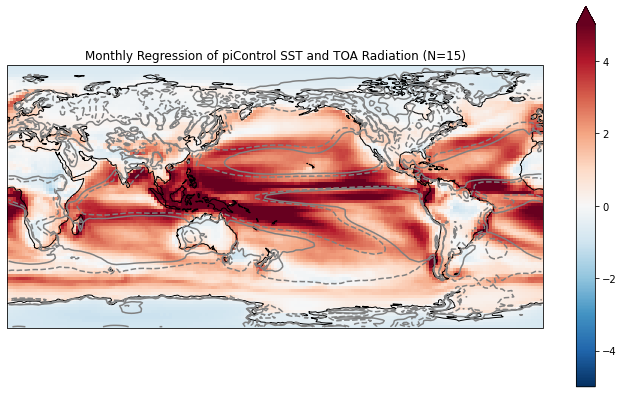

In [17]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_fit_cont_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-5, vmax=5, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly Regression of piControl SST and TOA Radiation (N=15)')

### New dataset

Text(0.5, 1.0, 'Monthly Regression of piControl SST and TOA Radiation (N=15)')

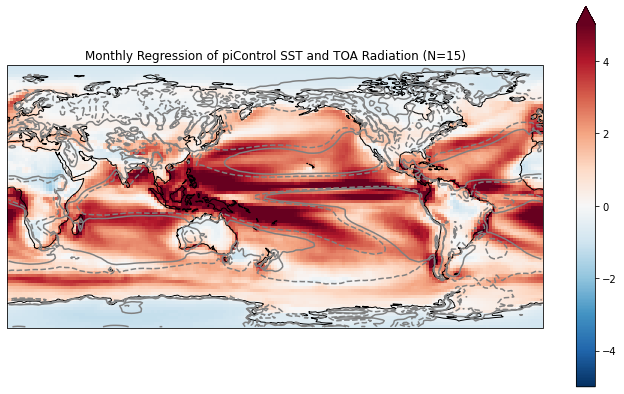

In [8]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_fit_cont_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-5, vmax=5, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly Regression of piControl SST and TOA Radiation (N=15)')

### Updated dataset (11/30)

Text(0.5, 1.0, 'Monthly Regression of piControl SST and TOA Radiation (N=15)')

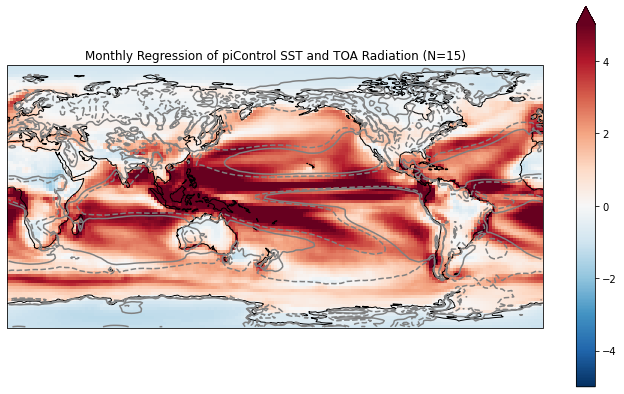

In [17]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_fit_cont_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-5, vmax=5, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly Regression of piControl SST and TOA Radiation (N=15)')

# Historical SST + TOA Radiation

In [4]:
dataarray_SST_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_sst_historical_interp_2x2_15memens_2.nc')
dataarray_SST_hist.load()

<xarray.DataArray 'ts' (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[239.72776031, 239.53605804, 239.34809875, ..., 240.49983902,
          240.30604935, 240.1127449 ],
         [240.23345566, 239.97485275, 239.77496338, ..., 241.80661621,
          241.39434052, 240.98330078],
         [243.2986824 , 242.81429367, 242.3306694 , ..., 245.59127121,
          244.97409439, 244.35900955],
         ...,
         [235.44582748, 235.47166901, 235.43232727, ..., 234.96419678,
          234.82762527, 234.71180573],
         [233.68259659, 233.6655426 , 233.69393539, ..., 234.22458344,
          234.07438278, 233.92438049],
         [232.4060318 , 232.32654114, 232.25035477, ..., 232.72785187,
          232.64683914, 232.56618195]],

        [[229.81121674, 229.64753647, 229.48410797, ..., 230.47428207,
          230.30729675, 230.14108734],
         [230.54207993, 230.24901428, 230.08576584, ..., 232.20073166,
          231.78198624, 231.36517029],
         [233.43589401, 233.01901398, 232.61507416, ..., 235.92978363,
          235.31613922, 234.70119934],
...
         [253.5345807 , 253.62416859, 253.69687856, ..., 252.92499209,
          253.30769977, 253.40706583],
         [252.19553908, 252.21278911, 252.23002734, ..., 252.18424604,
          252.13351638, 252.15487338],
         [250.74838405, 250.75130838, 250.75423612, ..., 250.80454796,
          250.78808492, 250.7716162 ]],

        [[238.65758206, 238.53384663, 238.41010391, ..., 239.38124703,
          239.19216301, 239.00308465],
         [238.65255689, 238.40425581, 238.15596025, ..., 239.97529907,
          239.60325604, 239.27263674],
         [240.91002447, 240.37961032, 239.84836888, ..., 242.76911442,
          242.38854589, 241.9071123 ],
         ...,
         [248.88179831, 249.23645723, 249.55722985, ..., 247.64610281,
          247.93472235, 248.24773801],
         [248.91423681, 249.04374118, 249.17324417, ..., 248.24221544,
          248.36503936, 248.55882082],
         [248.6031107 , 248.60378665, 248.60446968, ..., 248.54380519,
          248.56065276, 248.5774984 ]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'GFDL-ESM4' 'IPSL-CM6A-LR' ... 'NESM3' 'EC-Earth3'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    interp_method:  conserve_order2
    long_name:      Surface Temperature
    original_name:  ts
    standard_name:  surface_temperature
    units:          K

In [7]:
dataarray_TOA_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_toa_historical_2x2_15memens_2.nc')
dataarray_TOA_hist.load()

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[ -40.49030979,  -40.32841723,  -40.15647016, ...,
           -41.32518471,  -41.08868307,  -40.84039917],
         [ -42.01022983,  -41.68497341,  -41.42744581, ...,
           -43.62237048,  -43.20047472,  -42.74571177],
         [ -43.5138593 ,  -42.96715505,  -42.56623642, ...,
           -46.3825265 ,  -45.57779348,  -44.89683021],
         ...,
         [-166.95976342, -167.16756319, -167.15837071, ...,
          -166.39793223, -166.75592155, -166.85977288],
         [-165.70908805, -165.75021959, -165.77962253, ...,
          -165.30953577, -165.44865076, -165.59472732],
         [-164.95253744, -165.03962522, -165.17467822, ...,
          -164.87384663, -165.06615504, -164.99160661]],

        [[ -77.64925593,  -77.38441756,  -77.12490828, ...,
           -78.73775416,  -78.47043612,  -78.18227489],
         [ -79.8017584 ,  -79.43750621,  -79.0456798 , ...,
           -81.49615103,  -81.01476512,  -80.59659103],
         [ -83.09610685,  -82.41270824,  -81.7879474 , ...,
           -86.35207228,  -85.49494116,  -84.66419917],
...
         [-166.81720774, -167.1349408 , -167.56473694, ...,
          -166.52622518, -166.49926402, -166.77193787],
         [-165.19543482, -165.2637001 , -165.46430969, ...,
          -165.07179133, -164.91848373, -165.01286163],
         [-164.65316625, -164.84608826, -164.94760691, ...,
          -164.2806604 , -164.38411051, -164.37145752]],

        [[ -26.80411194,  -26.84976288,  -26.72195282, ...,
           -27.38051971,  -27.17290649,  -27.15810669],
         [ -29.08743184,  -28.44484711,  -28.11309306, ...,
           -29.78009949,  -29.54253896,  -29.73388367],
         [ -31.17776662,  -30.86613007,  -30.63884786, ...,
           -31.43811493,  -31.47828318,  -31.67970123],
         ...,
         [-161.70679693, -162.39194977, -162.19608459, ...,
          -159.42844554, -160.24482752, -160.79710464],
         [-159.60548859, -159.88904724, -160.19203186, ...,
          -158.3852712 , -158.66558965, -158.97713547],
         [-158.82939016, -158.98393814, -159.09867732, ...,
          -158.2918249 , -158.30172501, -158.55916   ]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'NESM3' 'UKESM1-0-LL'

In [8]:
sst_toa_hist_fit = monthly_fit(dataarray_SST_hist, dataarray_TOA_hist)

BCC-CSM2-MR
BCC-ESM1
CESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
EC-Earth3
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
NESM3
UKESM1-0-LL


In [9]:
sst_toa_hist_fit

<xarray.DataArray (name: 15, lat: 88, lon: 179)>
array([[[-9.26626270e-03, -1.03499422e-02, -1.16344658e-02, ...,
         -2.72017508e-03, -5.57168149e-03, -6.63099024e-03],
        [-1.95116590e-02, -2.18473502e-02, -2.35091809e-02, ...,
         -9.52218422e-03, -1.26243931e-02, -1.45518336e-02],
        [-2.51005479e-02, -2.57259287e-02, -2.75943647e-02, ...,
         -1.53464911e-02, -1.83039383e-02, -2.14948721e-02],
        ...,
        [-3.18296820e-02, -2.88875395e-02, -2.53674765e-02, ...,
         -4.10893915e-02, -3.87369687e-02, -3.59789298e-02],
        [-4.73848646e-02, -4.59911727e-02, -4.47177855e-02, ...,
         -4.82575568e-02, -4.91074694e-02, -4.89283870e-02],
        [-4.77088660e-02, -4.72506817e-02, -4.79004716e-02, ...,
         -5.06486208e-02, -4.95091243e-02, -4.86445922e-02]],

       [[-1.74264398e-02, -1.78191765e-02, -1.59455893e-02, ...,
         -2.27746628e-02, -2.10200377e-02, -2.00391890e-02],
        [-1.69939908e-02, -1.54223073e-02, -1.32245269e-02, ...,
         -2.67746810e-02, -2.40316364e-02, -2.25192482e-02],
        [-2.42376180e-02, -2.22004999e-02, -2.04104442e-02, ...,
         -3.36351811e-02, -3.09453570e-02, -2.88897305e-02],
...
        [ 8.05557202e-02,  8.23376865e-02,  8.56869062e-02, ...,
          6.54746334e-02,  6.79516192e-02,  7.42888449e-02],
        [ 6.58978768e-02,  6.61279127e-02,  6.93109074e-02, ...,
          5.18689659e-02,  5.59647005e-02,  5.90466471e-02],
        [ 3.78226013e-02,  3.81359194e-02,  3.81759826e-02, ...,
          3.27897072e-02,  3.45878221e-02,  3.65276480e-02]],

       [[ 2.58353400e-02,  2.60858515e-02,  2.56704618e-02, ...,
          2.14432330e-02,  2.19709955e-02,  2.31923689e-02],
        [ 2.43608362e-02,  2.43647412e-02,  2.54006745e-02, ...,
          1.96103380e-02,  2.24396696e-02,  2.35860900e-02],
        [-2.12107657e-03, -1.08426189e-03,  2.12146994e-03, ...,
         -7.86807177e-03, -7.89142238e-03, -6.70761473e-03],
        ...,
        [-6.75868731e-02, -6.42870891e-02, -6.02916170e-02, ...,
         -7.93898542e-02, -7.96304376e-02, -7.86212321e-02],
        [-7.95632323e-02, -7.73762758e-02, -7.56565389e-02, ...,
         -8.98170124e-02, -8.87182212e-02, -8.54410327e-02],
        [-7.25606779e-02, -7.07785138e-02, -7.09962982e-02, ...,
         -7.55102128e-02, -7.57869272e-02, -7.45111640e-02]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'NESM3' 'UKESM1-0-LL'

In [10]:
sst_toa_hist_fit_mean = sst_toa_hist_fit.mean('name')

## with seasonality

Text(0.5, 1.0, 'Regression of Historical SST and TOA Radiation (N=15)')

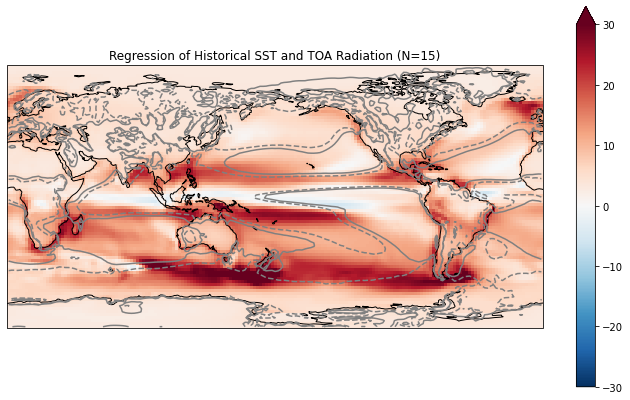

In [13]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_hist_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-30, vmax=30, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Regression of Historical SST and TOA Radiation (N=15)')

## Seasonality removed

Text(0.5, 1.0, 'Monthly Regression of Historical SST and TOA Radiation (N=15)')

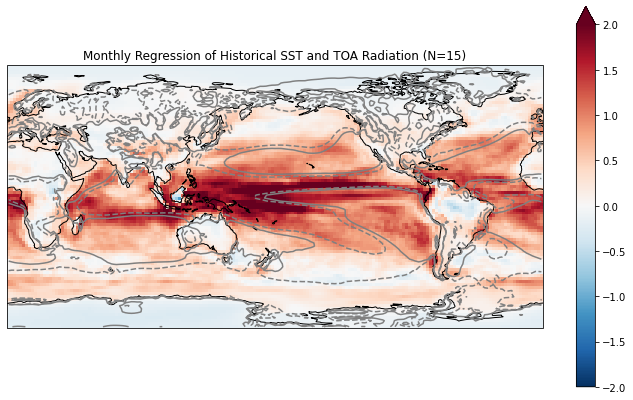

In [22]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_hist_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=2, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly Regression of Historical SST and TOA Radiation (N=15)')

## different datasets used

Text(0.5, 1.0, 'Monthly Regression of Historical SST and TOA Radiation (N=15)')

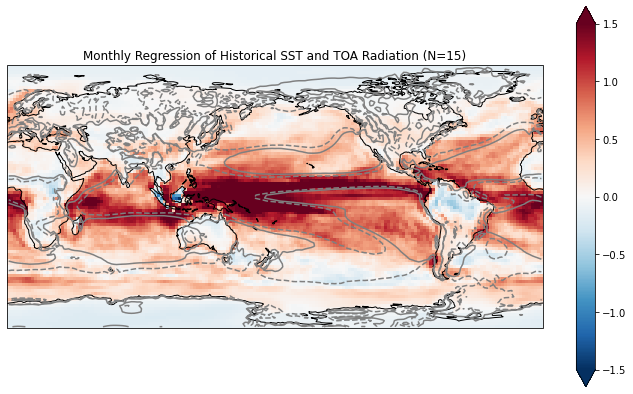

In [12]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_toa_hist_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-1.5, vmax=1.5, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly Regression of Historical SST and TOA Radiation (N=15)')

# SST + Surface Radiation

## piControl

In [5]:
surface_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_piControl_2x2_15memens.nc')

In [7]:
dataarray_SST_cont = dataarray_SST_cont.isel(time=slice(0,1500))
sst_surface_cont_fit = monthly_fit(dataarray_SST_cont, surface_cont)

BCC-CSM2-MR
BCC-ESM1
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
E3SM-1-0
FGOALS-g3
HadGEM3-GC31-LL
MIROC6
MPI-ESM-1-2-HAM
GFDL-CM4
GFDL-ESM4
GISS-E2-1-G
IPSL-CM6A-LR


In [8]:
sst_surface_cont_fit_mean = sst_surface_cont_fit.mean('name')

Text(0.5, 1.0, 'Monthly Regression of piControl SST and Surface Radiation Flux (N=15)')

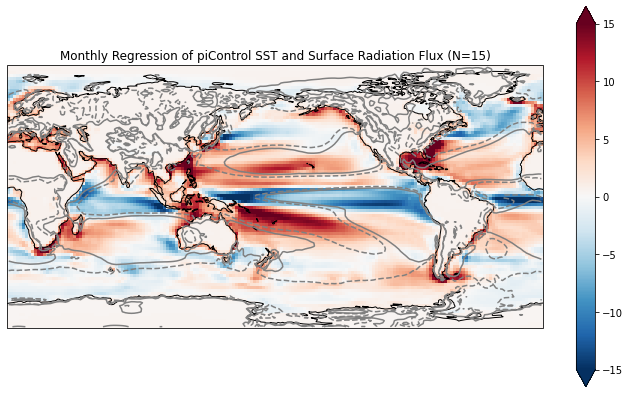

In [11]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surface_cont_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-15, vmax=15, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly Regression of piControl SST and Surface Radiation Flux (N=15)')

## historical

In [13]:
surface_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_surface_hist_interp_15memens_2.nc')
surface_hist.load()

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[ 4.90165056e+00,  5.02030481e+00,  5.14833517e+00, ...,
           4.42925605e+00,  4.56485558e+00,  4.66646627e+00],
         [ 4.59733384e+00,  4.82168076e+00,  4.98723783e+00, ...,
           3.81284670e+00,  3.96564983e+00,  4.19904078e+00],
         [ 4.02822119e+00,  4.18452456e+00,  4.37871187e+00, ...,
           3.16195200e+00,  3.32776068e+00,  3.54453707e+00],
         ...,
         [-3.46124473e+01, -3.68575683e+01, -3.48434307e+01, ...,
          -3.44554857e+01, -3.57958553e+01, -3.51358641e+01],
         [-3.32735436e+01, -3.38893754e+01, -3.38385741e+01, ...,
          -3.26756667e+01, -3.27437460e+01, -3.27906597e+01],
         [-3.46177860e+01, -3.51192427e+01, -3.58445793e+01, ...,
          -3.36690564e+01, -3.51623532e+01, -3.55597275e+01]],

        [[-2.86197465e+00, -2.93874279e+00, -3.03927916e+00, ...,
          -2.56575976e+00, -2.67832265e+00, -2.74031600e+00],
         [-2.12785747e+00, -2.32005957e+00, -2.40554916e+00, ...,
          -1.76238901e+00, -1.80849465e+00, -1.92474648e+00],
         [-1.41721594e+00, -1.48068312e+00, -1.55627523e+00, ...,
          -9.75113796e-01, -1.02866159e+00, -1.15787975e+00],
...
         [-2.78088935e+01, -2.78776526e+01, -2.93542580e+01, ...,
          -1.90225108e+01, -1.93425562e+01, -2.20628261e+01],
         [-2.44885393e+01, -2.53342339e+01, -2.67468318e+01, ...,
          -1.73685251e+01, -2.00562108e+01, -2.04017211e+01],
         [-2.17705019e+01, -2.34594400e+01, -2.61322040e+01, ...,
          -2.20741132e+01, -2.23441102e+01, -2.22555440e+01]],

        [[ 2.00020313e+01,  2.02547712e+01,  2.04408099e+01, ...,
           1.97594779e+01,  1.98033927e+01,  1.99940870e+01],
         [ 1.87190357e+01,  1.87650739e+01,  1.88504934e+01, ...,
           1.84766899e+01,  1.86177975e+01,  1.85550708e+01],
         [ 1.79714223e+01,  1.81370286e+01,  1.83174774e+01, ...,
           1.72408851e+01,  1.75626934e+01,  1.76884266e+01],
         ...,
         [-3.28068227e+01, -3.18609009e+01, -3.11594645e+01, ...,
          -2.05865988e+01, -2.25901160e+01, -2.73886632e+01],
         [-2.14137497e+01, -2.32414394e+01, -2.30369152e+01, ...,
          -1.75088925e+01, -1.97793967e+01, -2.07191078e+01],
         [-2.20522095e+01, -2.36049736e+01, -2.36618611e+01, ...,
          -2.03961387e+01, -2.12793080e+01, -2.13185888e+01]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'UKESM1-0-LL' 'NESM3'

In [14]:
sst_surface_fit = monthly_fit(dataarray_SST_hist, surface_hist)

BCC-CSM2-MR
BCC-ESM1
CESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
EC-Earth3
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
UKESM1-0-LL
NESM3


In [15]:
sst_surface_fit

<xarray.DataArray (name: 15, lat: 88, lon: 179)>
array([[[-2.39025662e-02, -2.39846711e-02, -2.54681968e-02, ...,
         -2.05602385e-02, -2.27208463e-02, -2.25231739e-02],
        [-2.87433577e-02, -3.11626271e-02, -3.26362506e-02, ...,
         -2.31943283e-02, -2.44560545e-02, -2.58732015e-02],
        [-2.06182026e-02, -2.29350937e-02, -2.53273520e-02, ...,
         -1.11095643e-02, -1.29435499e-02, -1.56695517e-02],
        ...,
        [-6.65969922e-03, -1.39991367e-02, -1.38962103e-02, ...,
         -3.41920515e-02, -1.66269798e-02, -4.37359896e-03],
        [-3.92609472e-03,  8.42196358e-04,  9.86860856e-03, ...,
         -4.58792579e-02, -3.73626516e-02, -2.61615180e-02],
        [-2.58816561e-03,  1.53905294e-02,  2.39730741e-02, ...,
         -2.97035850e-02, -1.49086962e-02, -6.34778620e-03]],

       [[-9.27394915e-03, -9.41537824e-03, -9.67600709e-03, ...,
         -7.48699347e-03, -7.72004814e-03, -7.59470945e-03],
        [-7.66941750e-03, -8.44117860e-03, -8.83603169e-03, ...,
         -2.57086760e-03, -3.29267402e-03, -3.93038036e-03],
        [-6.45127329e-03, -8.11043213e-03, -9.59120571e-03, ...,
         -5.42060493e-05, -1.18192638e-03, -2.63914710e-03],
...
        [ 5.66868712e-03,  6.73381932e-03,  2.15171723e-03, ...,
          2.73207113e-02,  1.85413058e-02,  1.54371618e-02],
        [ 7.80791921e-03,  7.25146020e-03,  4.20147627e-03, ...,
          5.85151704e-03,  8.12691048e-03,  7.98837108e-03],
        [-1.09988190e-02, -9.79091994e-03, -1.28751872e-02, ...,
         -1.37104323e-02, -1.36591705e-02, -1.39249264e-02]],

       [[ 4.43673536e-02,  4.33510965e-02,  4.05103824e-02, ...,
          5.41155375e-02,  5.02180925e-02,  4.94178810e-02],
        [ 3.53035164e-02,  3.40928074e-02,  3.06998430e-02, ...,
          4.47268844e-02,  4.08950898e-02,  3.84816412e-02],
        [ 7.21394740e-03,  6.55428446e-03,  4.48289669e-03, ...,
          1.81685705e-02,  1.60935843e-02,  1.40639653e-02],
        ...,
        [-2.51353572e-02, -4.68035053e-02, -5.21287475e-02, ...,
          1.35233545e-02,  8.63830170e-03,  1.86576568e-04],
        [-3.19892203e-02, -2.99834101e-02, -3.58806864e-02, ...,
          2.76185033e-04, -5.95974836e-03, -1.37247609e-02],
        [-5.08814074e-02, -4.24266800e-02, -3.88220948e-02, ...,
         -5.00933445e-02, -5.37384068e-02, -5.77955118e-02]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'UKESM1-0-LL' 'NESM3'

In [16]:
sst_surface_fit_mean = sst_surface_fit.mean('name')
sst_surface_fit_mean

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.09082594, 0.09094553, 0.09095849, ..., 0.09126513, 0.09096745,
        0.09110918],
       [0.08913956, 0.08897943, 0.08926034, ..., 0.09029868, 0.08993212,
        0.089544  ],
       [0.08441634, 0.08430806, 0.08440284, ..., 0.08592789, 0.08543344,
        0.08522077],
       ...,
       [0.07757415, 0.07471211, 0.07200868, ..., 0.06292052, 0.07160595,
        0.0781265 ],
       [0.08102311, 0.08347217, 0.08605058, ..., 0.07337144, 0.07614031,
        0.07771761],
       [0.07408474, 0.07666851, 0.07806573, ..., 0.07181938, 0.072383  ,
        0.07276991]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87

Text(0.5, 1.0, 'Monthly regression of Historical SST and Surface Radiation (N=15)')

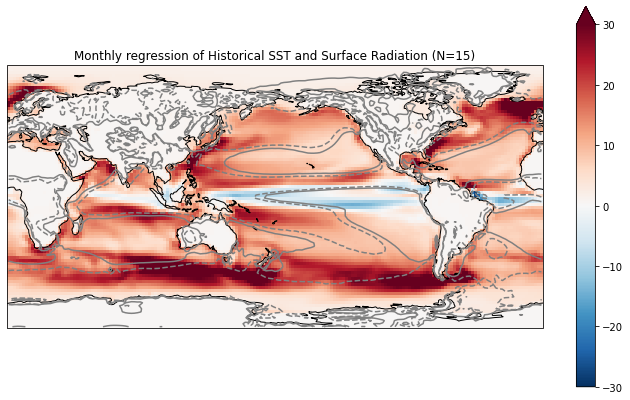

In [12]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surface_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-30, vmax=30, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly regression of Historical SST and Surface Radiation (N=15)')

Text(0.5, 1.0, 'Monthly regression of Historical SST and Surface Radiation (N=15)')

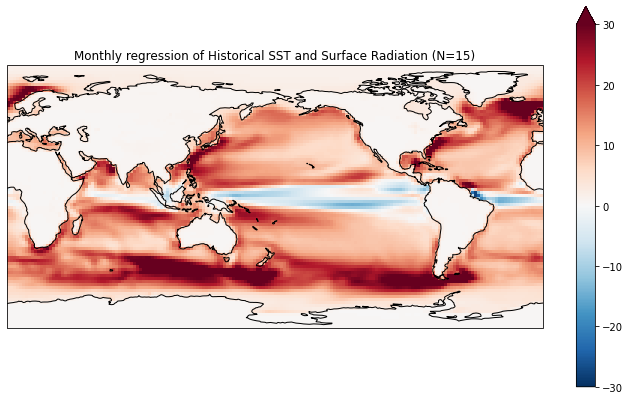

In [13]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surface_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-30, vmax=30, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly regression of Historical SST and Surface Radiation (N=15)')

## Monthly regression with seasonality removed

Text(0.5, 1.0, 'Monthly regression of Historical SST and Surface Radiation (N=15)')

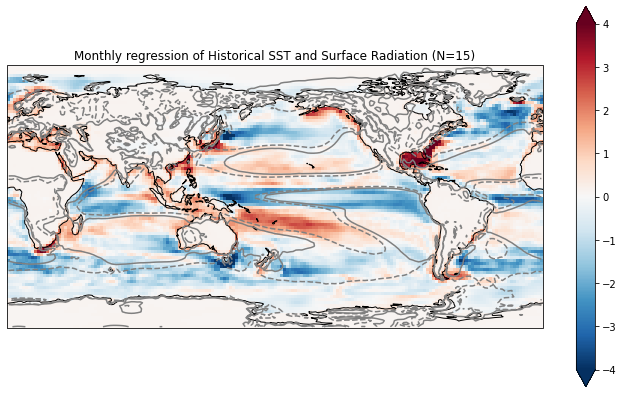

In [12]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surface_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-4, vmax=4, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly regression of Historical SST and Surface Radiation (N=15)')

Text(0.5, 1.0, 'Monthly regression of Historical SST and Surface Radiation (N=15)')

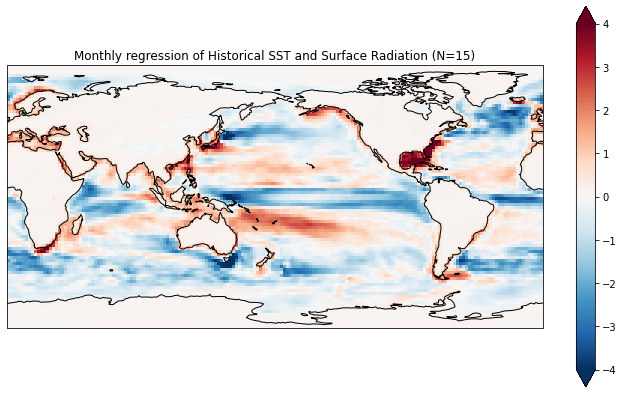

In [13]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surface_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-4, vmax=4, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly regression of Historical SST and Surface Radiation (N=15)')

## With changed dataset

Text(0.5, 1.0, 'Monthly regression of Historical SST and Surface Radiation (N=15)')

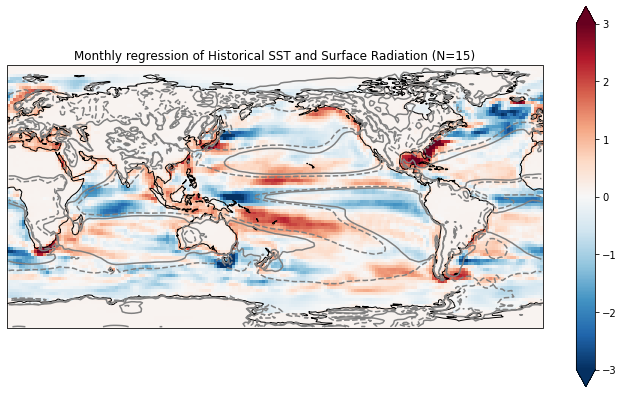

In [21]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surface_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-3, vmax=3, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly regression of Historical SST and Surface Radiation (N=15)')

Text(0.5, 1.0, 'Monthly regression of Historical SST and Surface Radiation (N=15)')

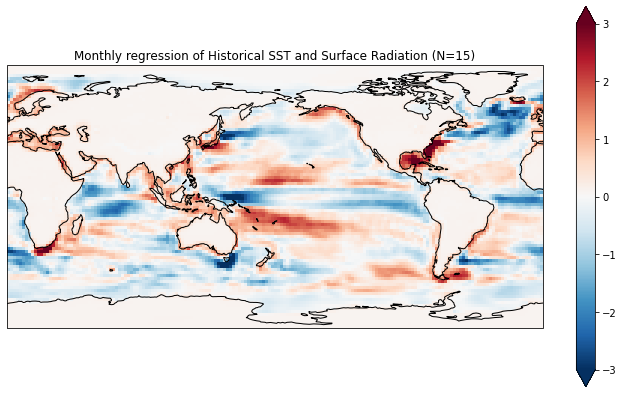

In [22]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_surface_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-3, vmax=3, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly regression of Historical SST and Surface Radiation (N=15)')

# Horizontal Radiation and SST

In [5]:
dataarray_horiz_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_hist_2x2_15memens_2.nc')

dataarray_horiz_cont = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_horiz_piControl_2x2_15memens.nc')

In [6]:
dataarray_horiz_cont

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
[354420000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'IPSL-CM6A-LR'

In [24]:
dataarray_horiz_hist

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
[354420000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'UKESM1-0-LL' 'NESM3'

In [25]:
sst_horiz_fit = monthly_fit(dataarray_SST_hist, dataarray_horiz_hist)

BCC-CSM2-MR
BCC-ESM1
CESM2
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
EC-Earth3
GFDL-ESM4
GISS-E2-1-G
HadGEM3-GC31-LL
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
UKESM1-0-LL
NESM3


In [26]:
sst_horiz_fit

<xarray.DataArray (name: 15, lat: 88, lon: 179)>
array([[[-1.46363074e-02, -1.36347254e-02, -1.38337273e-02, ...,
         -1.78400690e-02, -1.71491636e-02, -1.58921824e-02],
        [-9.23168594e-03, -9.31527823e-03, -9.12707434e-03, ...,
         -1.36721375e-02, -1.18316535e-02, -1.13213633e-02],
        [ 4.48234392e-03,  2.79082069e-03,  2.26700226e-03, ...,
          4.23692450e-03,  5.36038392e-03,  5.82529461e-03],
        ...,
        [ 2.51699777e-02,  1.48884016e-02,  1.14712709e-02, ...,
          6.89734306e-03,  2.21099961e-02,  3.16053379e-02],
        [ 4.34587824e-02,  4.68333786e-02,  5.45863994e-02, ...,
          2.37831689e-03,  1.17448255e-02,  2.27668715e-02],
        [ 4.51206856e-02,  6.26412324e-02,  7.18735433e-02, ...,
          2.09450481e-02,  3.46004663e-02,  4.22967810e-02]],

       [[ 8.15248947e-03,  8.40379821e-03,  6.26958246e-03, ...,
          1.52876714e-02,  1.32999882e-02,  1.24444804e-02],
        [ 9.32458064e-03,  6.98111556e-03,  4.38849327e-03, ...,
          2.42038169e-02,  2.07389650e-02,  1.85888594e-02],
        [ 1.77863525e-02,  1.40900714e-02,  1.08192358e-02, ...,
          3.35809711e-02,  2.97634360e-02,  2.62506027e-02],
...
        [ 7.32555646e-02,  7.10209164e-02,  6.24433185e-02, ...,
          1.06710570e-01,  9.81717445e-02,  9.40583841e-02],
        [ 8.73711667e-02,  8.46277456e-02,  7.98580083e-02, ...,
          9.56685454e-02,  9.68451178e-02,  9.34293717e-02],
        [ 6.15618728e-02,  6.09875593e-02,  5.81211120e-02, ...,
          6.17997916e-02,  6.21277592e-02,  6.05862206e-02]],

       [[ 7.24834905e-02,  6.98005677e-02,  6.56558542e-02, ...,
          9.15146561e-02,  8.44513089e-02,  8.23979472e-02],
        [ 6.90611346e-02,  6.96083264e-02,  6.00249607e-02, ...,
          7.67299869e-02,  7.03299770e-02,  6.91172253e-02],
        [ 4.11474390e-02,  4.03680494e-02,  4.21985445e-02, ...,
          5.08578641e-02,  5.12293620e-02,  4.95920060e-02],
        ...,
        [-1.05691077e-01, -1.29141192e-01, -1.37815654e-01, ...,
         -5.19512789e-02, -5.93133175e-02, -7.41022683e-02],
        [-9.78870971e-02, -9.61113228e-02, -1.05191594e-01, ...,
         -5.15927808e-02, -6.19244489e-02, -7.27714079e-02],
        [-8.87040087e-02, -8.05625995e-02, -7.69980774e-02, ...,
         -8.28830517e-02, -8.83262290e-02, -9.43231599e-02]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'UKESM1-0-LL' 'NESM3'

In [27]:
sst_horiz_fit_mean = sst_horiz_fit.mean('name')
sst_horiz_fit_mean

<xarray.DataArray (lat: 88, lon: 179)>
array([[0.25941819, 0.26093339, 0.26177632, ..., 0.25436522, 0.25560015,
        0.25723226],
       [0.25938528, 0.26092828, 0.25926077, ..., 0.24590862, 0.24879362,
        0.25378587],
       [0.2565351 , 0.25750738, 0.25776178, ..., 0.24843113, 0.25154085,
        0.2539059 ],
       ...,
       [0.2024364 , 0.19821332, 0.19375093, ..., 0.19518865, 0.20309464,
        0.20631658],
       [0.21895066, 0.22050972, 0.22287833, ..., 0.2165163 , 0.21858757,
        0.21757289],
       [0.22007638, 0.22192476, 0.22297297, ..., 0.22130211, 0.2203902 ,
        0.2194863 ]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87

Text(0.5, 1.0, 'Monthly regression of Historical SST and Horiz. Radiation Flux (N=15)')

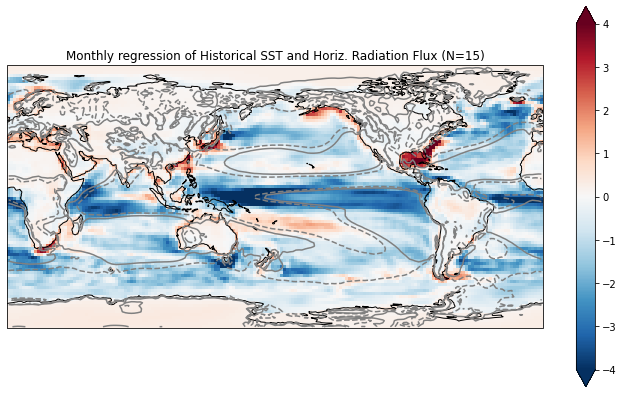

In [20]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_horiz_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-4, vmax=4, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly regression of Historical SST and Horiz. Radiation Flux (N=15)')

Text(0.5, 1.0, 'Monthly regression of Historical SST and Horiz. Radiation Flux (N=15)')

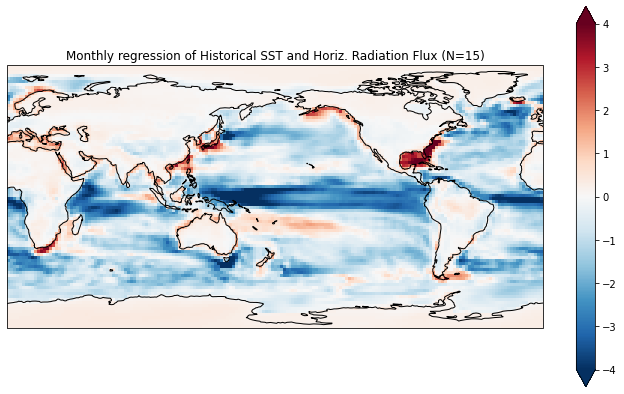

In [21]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_horiz_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-4, vmax=4, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly regression of Historical SST and Horiz. Radiation Flux (N=15)')

Text(0.5, 1.0, 'Monthly regression of Historical SST and Horiz. Radiation Flux (N=15)')

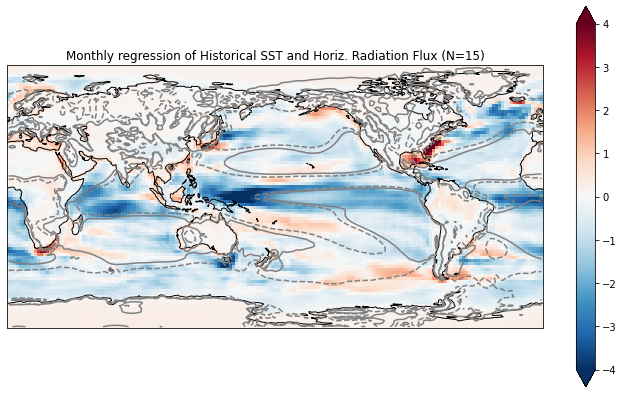

In [28]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_horiz_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-4, vmax=4, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly regression of Historical SST and Horiz. Radiation Flux (N=15)')

Text(0.5, 1.0, 'Monthly regression of Historical SST and Horiz. Radiation Flux (N=15)')

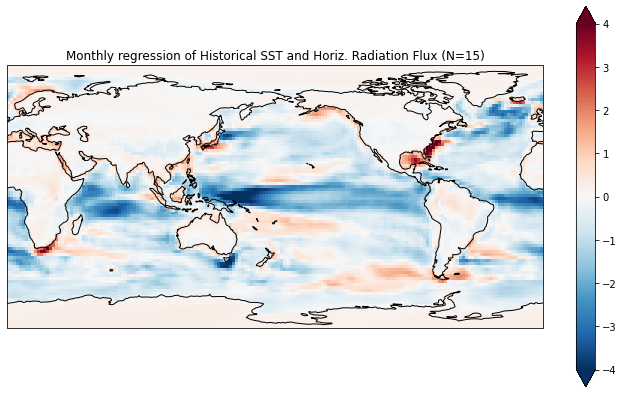

In [29]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_horiz_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-4, vmax=4, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly regression of Historical SST and Horiz. Radiation Flux (N=15)')

## piControl

In [8]:
dataarray_SST_cont = dataarray_SST_cont.isel(time=slice(0,1500))
sst_horiz_cont_fit = monthly_fit(dataarray_SST_cont, dataarray_horiz_cont)

BCC-CSM2-MR
BCC-ESM1
CNRM-CM6-1
CNRM-ESM2-1
CanESM5-CanOE
CanESM5
FGOALS-g3
GFDL-CM4
GFDL-ESM4
HadGEM3-GC31-LL
MIROC6
MPI-ESM-1-2-HAM
GISS-E2-1-G
E3SM-1-0
IPSL-CM6A-LR


In [9]:
sst_horiz_cont_fit_mean = sst_horiz_cont_fit.mean('name')

Text(0.5, 1.0, 'Monthly regression of piControl SST and Horiz. Radiation Flux (N=15)')

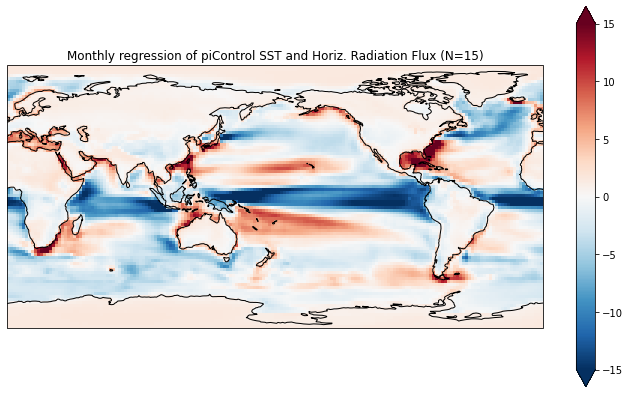

In [13]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_horiz_cont_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-15, vmax=15, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
plt.title('Monthly regression of piControl SST and Horiz. Radiation Flux (N=15)')

Text(0.5, 1.0, 'Monthly regression of piControl SST and Horiz. Radiation Flux (N=15)')

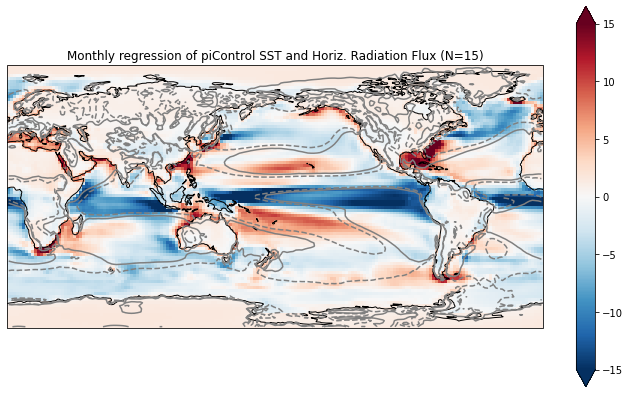

In [14]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_horiz_cont_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-15, vmax=15, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly regression of piControl SST and Horiz. Radiation Flux (N=15)')

# SST, Ocean Flux Regression

In [5]:
ocean_hist = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/CMIP_ocean_hist_2x2_15memens.nc')
ocean_hist.load()

<xarray.DataArray (time: 1500, name: 15, lat: 88, lon: 179)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
         [-2.00913279e+02, -2.06987688e+02, -2.11773237e+02, ...,
          -1.86808497e+02, -1.91565994e+02, -1.93877993e+02],
         [-1.86243472e+02, -1.59101203e+02, -1.34016263e+02, ...,
          -2.01979945e+02, -1.89616358e+02, -1.86784718e+02],
         [-2.78120102e+02, -2.79788083e+02, -2.83608347e+02, ...,
          -2.91542084e+02, -2.80639760e+02, -2.74256728e+02]],

        [[-7.15127588e+00, -7.17544508e+00, -7.19953938e+00, ...,
          -7.01900230e+00, -7.05338505e+00, -7.08768180e+00],
         [-7.09303928e+00, -7.18291887e+00, -7.27283770e+00, ...,
          -6.71072006e+00, -6.79742267e+00, -6.89763858e+00],
         [-7.05300527e+00, -7.17045711e+00, -7.28742816e+00, ...,
          -6.54804259e+00, -6.66815613e+00, -6.79860768e+00],
         ...,
         [-1.61308705e+02, -1.44592885e+02, -1.34413314e+02, ...,
          -1.94769770e+02, -1.96659352e+02, -1.88590153e+02],
         [-1.06022143e+02, -9.88412029e+01, -9.27617527e+01, ...,
          -1.39612776e+02, -1.31027969e+02, -1.22683649e+02],
         [-3.96241346e+01, -3.84842441e+01, -3.72494463e+01, ...,
          -4.81284316e+01, -4.57977274e+01, -4.35754286e+01]]]])
Coordinates:
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * name     (name) object 'GFDL-ESM4' 'IPSL-CM6A-LR' ... 'NESM3' 'EC-Earth3'

In [10]:
warnings.filterwarnings('ignore')
sst_ocean_fit = monthly_fit(dataarray_SST_hist, ocean_hist)

GFDL-ESM4
IPSL-CM6A-LR
GISS-E2-1-G
CNRM-CM6-1
BCC-CSM2-MR
CNRM-ESM2-1
BCC-ESM1
CESM2
UKESM1-0-LL
CanESM5
CanESM5-CanOE
HadGEM3-GC31-LL
MPI-ESM-1-2-HAM
NESM3
EC-Earth3


In [12]:
sst_ocean_fit_mean = sst_ocean_fit.mean('name')

Text(0.5, 1.0, 'Monthly Regression of Historical SST and Ocean Radiation Flux (N=15)')

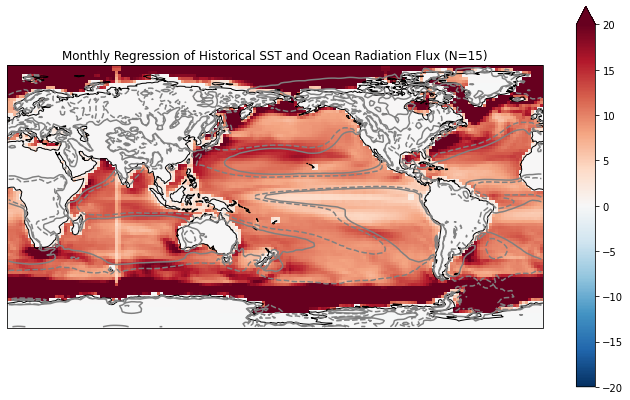

In [17]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_ocean_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-20, vmax=20, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly Regression of Historical SST and Ocean Radiation Flux (N=15)')

Text(0.5, 1.0, 'Monthly Regression of Historical SST and Ocean Radiation Flux (N=15)')

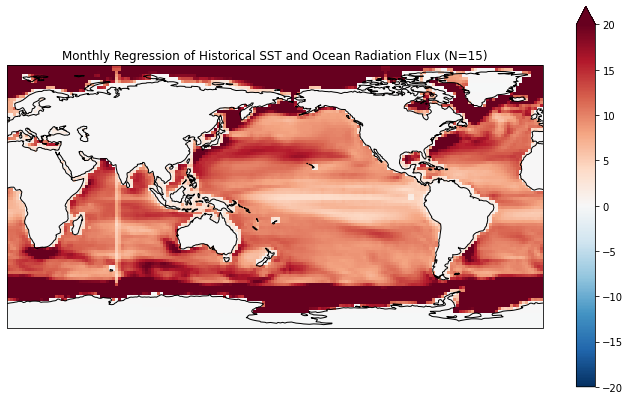

In [19]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
sst_ocean_fit_mean.plot(ax=ax, transform=ccrs.PlateCarree(), vmin=-20, vmax=20, cmap='RdBu_r')
ax.coastlines(color='black', linewidth=1)
#vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Monthly Regression of Historical SST and Ocean Radiation Flux (N=15)')

In [20]:
sst_ocean_fit_mean.to_netcdf('/data/keeling/a/mailes2/a/processed_var_data/sst_ocean_regression_hist.nc')

# Testing

In [10]:
dataarray_TOA_cont

<xarray.DataArray (name: 15, time: 1500, lat: 88, lon: 179)>
array([[[[ -36.71150756,  -36.54298704,  -36.33610696, ...,
           -37.38284098,  -37.20380278,  -36.99700632],
         [ -38.26714412,  -37.84095571,  -37.39639549, ...,
           -40.08008474,  -39.55886911,  -39.16305471],
         [ -41.73647855,  -41.19594878,  -40.66258   , ...,
           -43.8332355 ,  -43.39299072,  -42.8394849 ],
         ...,
         [-157.2955542 , -157.20398975, -157.24631113, ...,
          -157.04223199, -157.12361213, -157.20145457],
         [-157.91162539, -157.93890508, -157.92696253, ...,
          -158.0758101 , -158.08202094, -157.97277022],
         [-158.18000831, -158.15537339, -158.11918551, ...,
          -158.34951912, -158.36058747, -158.20792706]],

        [[ -72.54225605,  -72.23584524,  -71.96492355, ...,
           -73.75649012,  -73.41867717,  -73.11533206],
         [ -74.15452931,  -73.55173268,  -73.10056357, ...,
           -76.46964449,  -75.84088912,  -75.23099848],
         [ -76.72662193,  -75.94243471,  -75.26338409, ...,
           -80.29527136,  -79.42623765,  -78.51133988],
...
         [-188.02728653, -187.02527618, -186.92507553, ...,
          -187.55286789, -187.55036926, -187.54027557],
         [-185.22816467, -185.07926559, -185.23701859, ...,
          -185.39315796, -185.4220314 , -185.44599915],
         [-185.90256119, -185.94739914, -186.76815033, ...,
          -184.00166702, -185.02732086, -185.87574387]],

        [[ -22.5772934 ,  -22.41658783,  -20.48698425, ...,
           -23.0619278 ,  -21.95114136,  -22.51290894],
         [ -22.62309265,  -22.9865036 ,  -22.77677917, ...,
           -23.58843231,  -23.53172302,  -23.1353302 ],
         [ -23.33261871,  -21.22659302,  -21.00968933, ...,
           -18.84187317,  -18.88832855,  -19.24697113],
         ...,
         [-189.16456985, -189.84530258, -189.86688995, ...,
          -187.54803848, -187.52114105, -187.57167053],
         [-188.69926453, -188.78238297, -188.79423904, ...,
          -187.6062088 , -187.63004303, -188.10134506],
         [-185.94189072, -185.93039322, -185.61513138, ...,
          -185.5074234 , -185.52069092, -185.91252136]]]])
Coordinates:
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 1975-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'BCC-CSM2-MR' 'BCC-ESM1' ... 'GFDL-ESM4' 'E3SM-1-0'

In [11]:
dataarray_TOA_cont_timemean = dataarray_TOA_cont.mean('time')
dataarray_TOA_cont_mean = dataarray_TOA_cont_timemean.mean('name')

Text(0.5, 1.0, 'Average monthly TOA radiation (positive downwards) (N=15)')

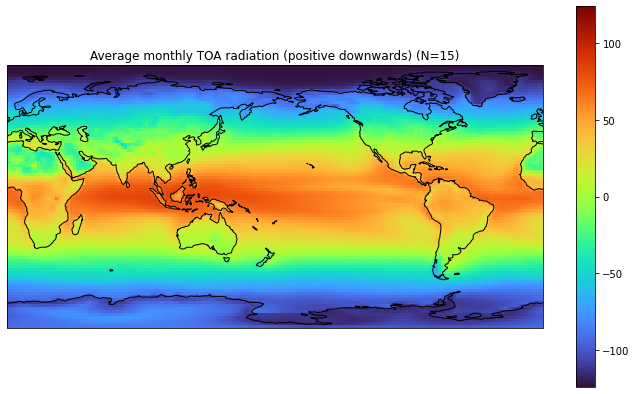

In [12]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
dataarray_TOA_cont_mean.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='turbo')
ax.coastlines(color='black', linewidth=1)
#vert_ds.plot.contour(ax=ax, transform=ccrs.PlateCarree(), colors='#808080', levels=[-0.005,0.005])
plt.title('Average monthly TOA radiation (positive downwards) (N=15)')